# An Empirical Evaluation of Gray World and Neural Network Approaches for Image White Balancing
### COMP  478/6771:   Image  Processing
#### Submitted by:
<ol> Ananya Varsha [40197012]
<br> Sivakumaran Malli Janardhanan [40155790]

### Necesary Code imports

The below cell consists of all the necessary code imports that have been used throughout the process. It is a cleaner and more feasible approach to have all the imports on the top of the notebook rather than including it in individual cells

In [ ]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow
import keras
import visualkeras




from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, ReLU, Concatenate, Conv2DTranspose
from keras.models import Model
from keras.layers import MaxPooling2D, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.callbacks import EarlyStopping
## print("Done importing")


### Static code variables declarations

This cell consists of all the majore variable declarations and static data that will be later utlised in this notebook

In [2]:
save_model_name = "awb"
# Size of the training images to be set before training
img_size = 256

#Array declartions for train/test images along with groung truth images
train_images = []
ground_truth_images = []
use_saved_model = True

### Image collection

This cell consists of the method to resize and append the images into an array. The images have been split into ground truth images and images for training, which are the tinted images

In [5]:
path=r"images/Bad"
counter_train_image = 0;
for image in os.listdir(path):
    # filteration to avoid hidden file added by MacOS
    if (image != ".DS_Store"):
        # Repeatedly iterate the folder to obtain all images
        imgages = cv2.imread(os.path.join(path,image) ,cv2.IMREAD_COLOR)
        # Resize the images for normalization
        train_images_array = cv2.resize(imgages, (img_size, img_size))
        train_images.append(train_images_array)
        #print("Saved train color image :",counter_train_image)
        counter_train_image+=1


path=r"images/Good"
counter_ground_image = 0;
for image in os.listdir(path):
    # filteration to avoid hidden file added by MacOS
    if (image != ".DS_Store"):
        # Repeatedly iterate the folder to obtain all images
        imgages = cv2.imread(os.path.join(path,image) ,cv2.IMREAD_COLOR)
        # Resize the images for normalization
        ground_images_array = cv2.resize(imgages, (img_size, img_size))
        ground_truth_images.append(ground_images_array)
        #print("Saved ground image :",counter_ground_image)
        counter_ground_image+=1

print("Saved both ground images and tinted images")

Saved both ground images and tinted images


### Display dataset images

The below cell picks 10 images and displays it in the console in a 2x5 grid


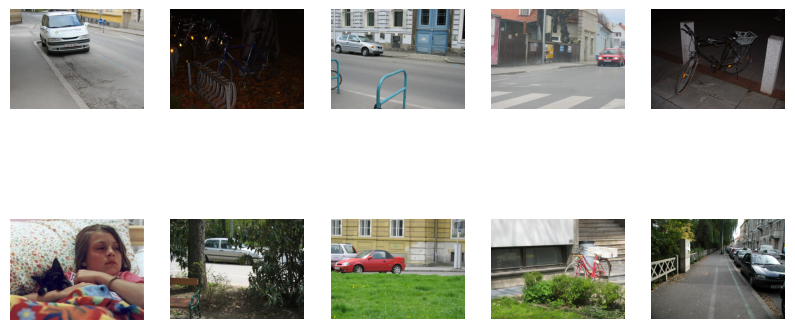

In [6]:
import os
import matplotlib.pyplot as plt

# Path to the folder containing the images
folder_path = "/Users/sivakumaran/Downloads/IP/COMP-6771-Project/image"

# Load all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Load the first 10 images
images = [plt.imread(f) for f in image_files[:10]]

# Create a new figure with a grid layout
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

# Display the images in the grid
for i, im in enumerate(images):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(im)
    axs[row, col].axis('off')

# Show the grid in the console
plt.show()

### Normalization & Split

Before supplying the pictures to a Convolutional Neural Network (CNN), image normalisation should be carried out as a preparatory step. By guaranteeing that the input values are on a same scale, normalisation can make it simpler for the network to understand the underlying patterns in the data.  We used an 80-20 split, with 80% training data and 20% test data

In [ ]:
train_images = (np.array(train_images))/255
ground_truth_images = (np.array(ground_truth_images))/255
train_image_for_train, train_image_for_test, ground_truth_train, ground_truth_test = train_test_split(train_images, ground_truth_images, test_size=0.2)
#print(len(train_image_for_train))
#print(len(train_image_for_test))
#print(len(ground_truth_train))
#print(len(ground_truth_test))

### Dataset split visualization

The below cell visualizes the data set both in terms of train/test split and the total images available for the Neural Network.

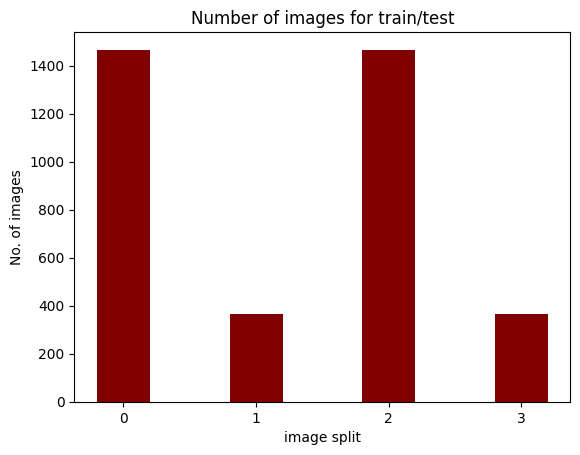

Legend

0 - train_image_for_train  1466
1 - train_image_for_test  367
2 - ground_truth_train  1466
3 - ground_truth_test  367


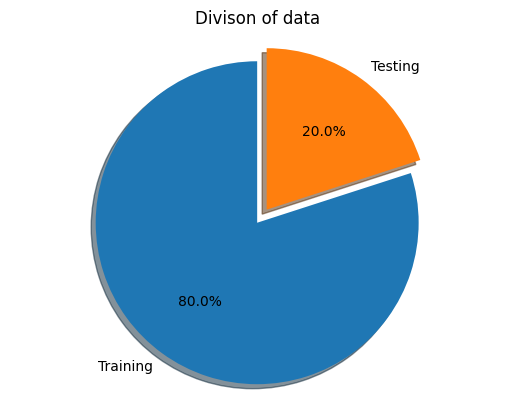

Total Data set Size:  3666
Train Image Size :  2932
Test Image Size :  734


In [5]:
data = {'0':len(train_image_for_train), "1":len(train_image_for_test), '2':len(ground_truth_train),"3":len(ground_truth_test)}
images = list(data.keys())
values = list(data.values())
plt.bar(images, values, color ='maroon',width = 0.4)
plt.xlabel("image split")
plt.ylabel("No. of images")
plt.title("Number of images for train/test")
plt.show()

print("Legend\n")
print("0 - train_image_for_train ",len(train_image_for_train))
print("1 - train_image_for_test ",len(train_image_for_test))
print("2 - ground_truth_train ",len(ground_truth_train))
print("3 - ground_truth_test ",len(ground_truth_test))

labels = 'Training', 'Testing'

sizes = [len(train_image_for_train) + len(ground_truth_train), len(train_image_for_test) + len(ground_truth_test)]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%",
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Divison of data")
plt.show()

print("Total Data set Size: ",len(train_image_for_train) + len(ground_truth_train) + len(train_image_for_test) + len(ground_truth_test))
print("Train Image Size : ",len(train_image_for_train) + len(ground_truth_train) )
print("Test Image Size : ",len(train_image_for_test) + len(ground_truth_test))


### Convolution Neural Network - UNet

The bellow cell defined all the necessary layers for our Neural Network. Three channels of a 256x256 RGB picture are designated as the input layer. Four convolutional layers make up the encoder layers, and each is followed by a ReLU activation function. Each consecutive layer of the encoder doubles the number of filters to 48, 96, and 192 from the first layer's 24 to the last.

The network's bottleneck is its bridge layers, which reduce the incoming data's dimensions for representation. A downsampling convolutional layer with 384 filters is used in this instance, and then an upsampling transpose convolutional layer with 192 filters.

The three blocks that make up the decoder layers each have three convolutional layers with 96, 48, and 24 filters. A ReLU activation function follows each convolutional layer. Each block's output is up-sampled using a transpose convolutional layer with a stride of 2, doubling the input's spatial resolution.

To combine the output of each decoder block with the corresponding encoder block, the concatenation operator is used. The final output of the network is an RGB image with the same spatial resolution as the input.

In [ ]:

# Define the input layer
input_layer = Input(shape=(256, 256, 3), name="Main Input")

# Define the encoder layers
encoder_inc = Conv2D(24, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name="encoder_inc")(input_layer)
encoder_down1 = Conv2D(48, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name="encoder_down1")(encoder_inc)
encoder_down2 = Conv2D(96, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name="encoder_down2")(encoder_down1)
encoder_down3 = Conv2D(192, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name="encoder_down3")(encoder_down2)

# Define the bridge layers
encoder_bridge_down = Conv2D(384, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name="encoder_bridge_down")(encoder_down3)
encoder_bridge_up = Conv2DTranspose(192, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name="encoder_bridge_up")(encoder_bridge_down)

#Define the decoder layers
print(encoder_down3, encoder_bridge_up)
concatenate_8 = Concatenate()([encoder_down3, encoder_bridge_up])
sequential_8 = Sequential([
    Conv2D(192, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(192, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(192, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
], name="sequential_8")(concatenate_8)
conv2d_transpose_9 = Conv2DTranspose(96, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name="conv2d_transpose_9")(sequential_8)

concatenate_9 = Concatenate()([encoder_down2, conv2d_transpose_9])
sequential_9 = Sequential([
    Conv2D(96, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(96, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(96, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
], name="sequential_9")(concatenate_9)
conv2d_transpose_10 = Conv2DTranspose(48, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name="conv2d_transpose_10")(sequential_9)

concatenate_10 = Concatenate()([encoder_down1, conv2d_transpose_10])
sequential_10 = Sequential([
    Conv2D(48, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(48, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(48, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
], name="sequential_10")(concatenate_10)
conv2d_transpose_11 = Conv2DTranspose(24, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name="conv2d_transpose_11")(sequential_10)

concatenate_11 = Concatenate()([input_layer, conv2d_transpose_11])
sequential_11 = Sequential([
    Conv2D(3, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(3, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(3, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
], name="sequential_11")(concatenate_11)

### Model Training

The below cell starts the training of a new model if it is not already preset. If a pre-trained model is present, the Keras pre-trained model will be utlised. The optimizer used here is Adam and the loss metric is Mean Squared Error. the number of epochs are 40 and the batch size is 32

In [7]:
model = Model(inputs=input_layer, outputs=sequential_11)
model.compile(optimizer='Adam', loss='mse',metrics=['accuracy','MeanSquaredError','mae', 'mape'])
if use_saved_model:
    model = keras.models.load_model("awb.h5")
else:
    print("Training new model\n")
    model_history = model.fit(train_image_for_train, ground_truth_train, epochs=40, batch_size=32, validation_data=(train_image_for_test, ground_truth_test))
if not use_saved_model:
    model.save("awb_test.h5")

### Visualize the model using TensorFlow plot_model

The below code will create a diagramatic representation of the Unet model that has been utilised

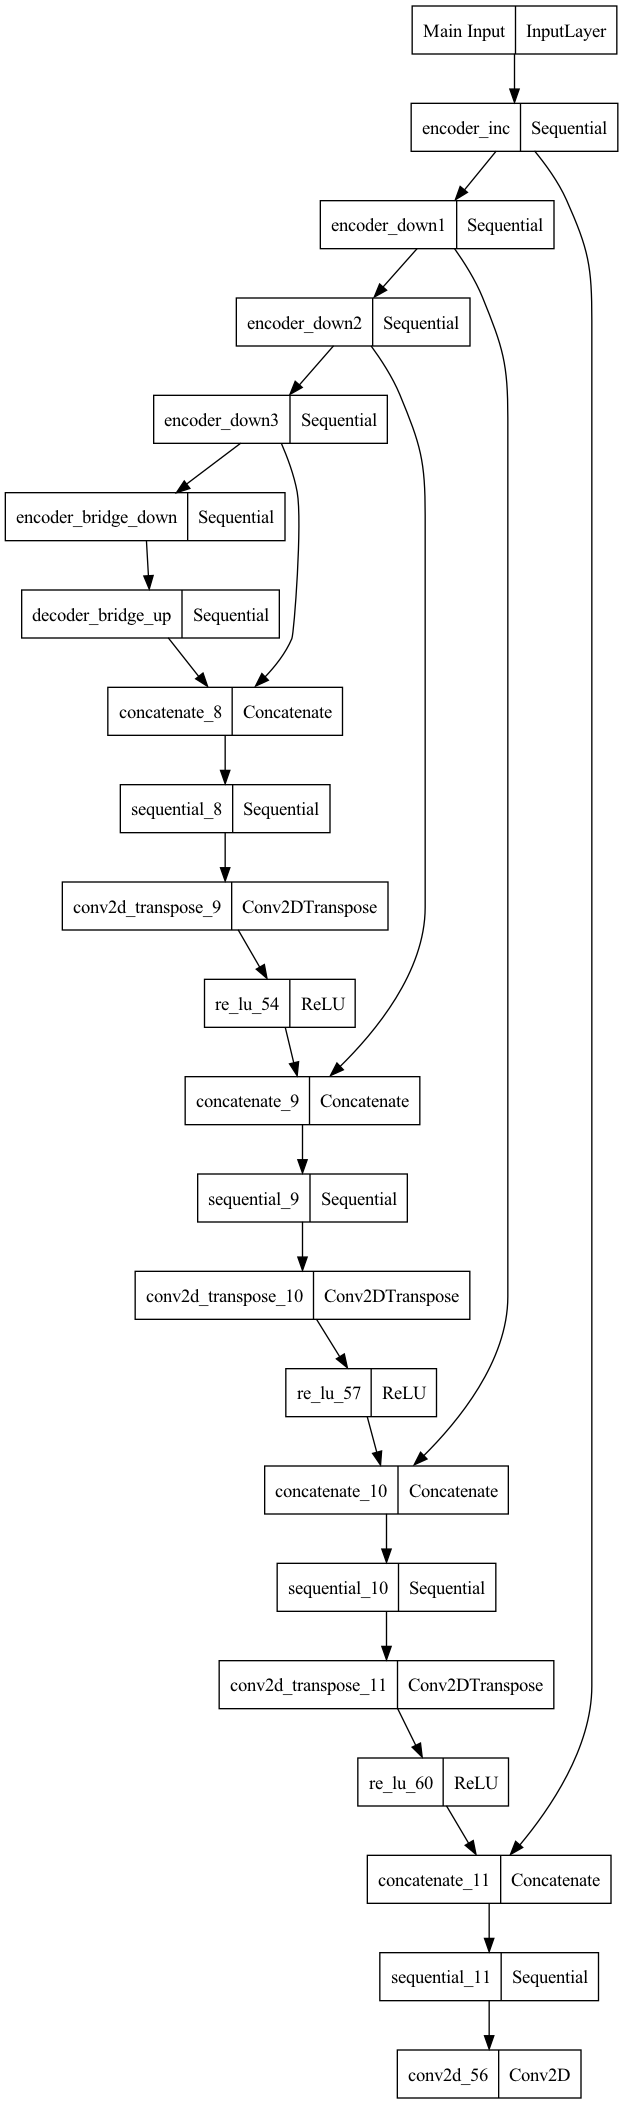

In [8]:
#visualkeras.layered_view(model,legend=True,scale_xy= 1.5).show()
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

### Metrics

The below cell will plot the essential metrics, like Mean Squared Error over epochs, Validation loss over epochs, and accuracy

In [ ]:
plt.plot(model_history.epoch, model_history.history['loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()


plt.plot(model_history.epoch, model_history.history['accuracy'])
plt.title('Epochs on Training accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(model_history.epoch, model_history.history['val_loss'])
plt.title('Epochs on validation loss')
plt.xlabel('# of Epochs')
plt.ylabel('validation loss')
plt.show()

### Model Predict

The below cell will be used to regenerate the new set of images from the testing split and store them in the resultant array

In [ ]:
result = model.predict(train_image_for_test)
model.evaluate(result, ground_truth_test)


### Plotting the image created by CNN

The below cell plots the original image, tinted image and the image generated using CNN to allow us to compare the results.

In [ ]:

plt.subplot(1,3,1)
plt.title("Ground Truth")
plt.imshow(ground_truth_test[1])
ax = plt.gca()
plt.axis('off')


plt.subplot(1,3,2)
plt.title("Tinted image")
plt.imshow(train_image_for_test[1])
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Unet")
plt.imshow(result[1])
plt.axis('off')

plt.show()

### Plotting the image created by Gray World method

The below cell plots the original image, tinted image and the image generated using Gray World Method to allow us to compare the results. It also consists of the algorithm used in the Gray World approach.

In [ ]:
img = cv2.imread("images/Bad/cat.4.jpg")

array = cv2.resize(img, (256, 256))
array = (np.array(array))/255

gw_result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
avg_a = np.average(gw_result[:, :, 1])
avg_b = np.average(gw_result[:, :, 2])
gw_result[:, :, 1] = gw_result[:, :, 1] - ((avg_a - 128) )
gw_result[:, :, 2] = gw_result[:, :, 2] - ((avg_b - 128) )
gw_result = cv2.cvtColor(gw_result, cv2.COLOR_LAB2BGR)

plt.subplot(1,3,1)
plt.title("Tinted Image")
plt.imshow(train_image_for_test[2])
plt.axis('off')
#plt.show()

plt.subplot(1,3,2)
plt.title("Gray world method")
plt.imshow(gw_result)
plt.axis('off')
#plt.show()

plt.subplot(1,3,3)
plt.title("CNN")
plt.imshow(result[2])
plt.axis('off')

plt.show()



### Peak Signal-to-Noise Ratio

The below cell calcualtes the peak signal-to-noise ratio (PSNR) between the images

In [ ]:
# Load the original image and corrected image
# Only for testing
orig_img = cv2.imread('images/Good/cat.1.jpg')
corr_img = cv2.imread('images/Bad/cat.1.jpg')

# Convert the images to grayscale and resize them to the same size
# Only for testing
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
corr_img = cv2.cvtColor(corr_img, cv2.COLOR_BGR2GRAY)

orig_img = cv2.resize(orig_img, (corr_img.shape[1], corr_img.shape[0]))

#gw_result = cv2.resize(gw_result, (256, 256))
# Compute the peak signal-to-noise ratio (PSNR) between the images
mse = np.mean((train_image_for_test[2] - result[2]) ** 2)
if mse == 0:
    psnr = float('inf')
else:
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))

# Print the PSNR value
print('PSNR:', psnr)